In [12]:
#fetch GFS data and plot at ENA
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import netCDF4
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import numpy as np
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS
from datetime import datetime, timedelta
from netCDF4 import num2date
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import ftplib
import pygrib
import tempfile
import xarray


%matplotlib inline

In [2]:
import imp
lib_loc = os.path.join(os.path.expanduser('~'), 'projects/ACE-ENA-EVA/code/ena_tools.py')
ena_tools = imp.load_source('ena_tools', lib_loc)


/Users/scollis/anaconda/envs/houston/lib/python3.5/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [310]:
def get_ecmwf_137():
    levels_loc = os.path.join(os.path.expanduser('~'), 'projects/ACE-ENA-EVA/ecmwf_137_levels.txt')
    levels = np.genfromtxt(levels_loc, missing_values='-')
    ht = levels[1::, 6]
    pres = levels[1::, 3]
    return ht, pres

def extract_3d_grib(grb_obj, search_term):
    grb_list = grb_obj.select(name=search_term)
    level_nums = [this_grb['level'] for this_grb in grb_list]
    order =  np.array(level_nums).argsort()
    lats, lons = grb_list[0].latlons()
    transfer_array = np.empty([len(order), lats.shape[0], lats.shape[1]])
    for i in range(len(order)):
        transfer_array[i,:,:] = grb_list[order[i]].values
    
    return transfer_array, lats, lons

def ecmwf_name_to_date(ename):
    start_time = datetime.strptime('2017'+ename[3:11], '%Y%m%d%H%M')
    valid_time = datetime.strptime('2017'+ename[11:19], '%Y%m%d%H%M')
    return start_time, valid_time

def file_list_to_date(file_list):
    start_times = [ecmwf_name_to_date(this_name)[0] for this_name in file_list]
    end_times = [ecmwf_name_to_date(this_name)[1] for this_name in file_list]
    return start_times, end_times

def get_run_hours(file_list):
    gen_t, val_t = file_list_to_date(file_list)
    gen_hour = np.array([dt.hour for dt in gen_t])
    return np.unique(gen_hour)

def get_time_for_run(file_list, gen_hour):
    gen_t, val_t = file_list_to_date(file_list)
    gen_hours = np.array([dt.hour for dt in gen_t])
    good_files = []
    good_times_gen = []
    good_times_val = []
    for i in range(len(gen_hours)):
        if gen_hours[i] == gen_hour:
            good_files.append(file_list[i])
            good_times_gen.append(gen_t[i])
            good_times_val.append(val_t[i])
    
    return good_files, good_times_gen, good_times_val

def create_bundle_latest(var_list, n=None):
    username_file = os.path.join(os.path.expanduser('~'), 'ecmwf_username')
    password_file = os.path.join(os.path.expanduser('~'), 'ecmwf_passwd')
    uname_fh = open(username_file, 'r')
    uname = uname_fh.readline()[0:-1]
    uname_fh.close()
    passwd_fh = open(password_file, 'r')
    passwd = passwd_fh.readline()[0:-1]
    passwd_fh.close()
    host = 'dissemination.ecmwf.int'
    
    #get ECMWF vert coord
    ht, pres = get_ecmwf_137()
    ftp = ftplib.FTP(host)
    ftp.login(user=uname, passwd = passwd )
    closest_now = datetime.utcnow().strftime('%Y%m%d')
    ftp.cwd(closest_now)
    lst = ftp.nlst()
    lst.sort()
    
    run_hours = get_run_hours(lst)
    target_files, generated_times, valid_times = get_time_for_run(lst, run_hours[-1])
    
    if n is None:
        these_target_files = target_files[1::]
        these_run_times = generated_times[1::]
        these_valid_times = valid_times[1::]
    else:
        these_target_files = target_files[1:n]
        these_run_times = generated_times[1:n]
        these_valid_times = valid_times[1:n]
    
    bundle = {}
    
    for var_name in var_list:
        bundle.update({var_name: []})
    
    for i in range(len(these_valid_times)):
        print(these_target_files[i])
        fh = tempfile.NamedTemporaryFile()
        ftp.retrbinary('RETR ' + these_target_files[i], fh.write)
        grbs = pygrib.open(fh.name)  
        grbs.seek(0)
        for var_name in var_list:
            this_step, lats, lons = extract_3d_grib(grbs, var_name)
            bundle[var_name].append(this_step)
        grbs.close()
    
    return bundle, these_valid_times, these_run_times, lats, lons
        

def concat_bundle(bundle):
    varss = list(bundle.keys())
    n_times = len(bundle[varss[0]])
    hlatlon = bundle[varss[0]][0].shape
    unwound = {}
    for this_var in varss:
        transfer = np.empty([n_times, 136, hlatlon[1], hlatlon[2]])
        for time_step in range(n_times):
            transfer[time_step, 0:136, :, :] = bundle[this_var][time_step][0:136, :, :]
        unwound.update({this_var: transfer})
    return unwound
          
def unwind_to_xarray(unwound, valid_times, lats, lons):
    ds = xarray.Dataset()
    for vvar in list(unwound.keys()): 
        my_data = xarray.DataArray(unwound[vvar], 
                                   dims = ('time', 'z', 'y', 'x'),
                                  coords = {'time' : (['time'], valid_times),
                                           'z' : (['z'], get_ecmwf_137()[0][0:136]),
                                           'lat' :(['y','x'], lats),
                                           'lon' : (['y','x'],my_lons)})
        ds[vvar.replace(' ', '_')] = my_data
    
    ds.lon.attrs = [('long_name', 'longitude of grid cell center'),
             ('units', 'degrees_east'),
             ('bounds', 'xv')]
    ds.lat.attrs = [('long_name', 'latitude of grid cell center'),
             ('units', 'degrees_north'),
             ('bounds', 'yv')]
    return ds    
    

In [3]:
username_file = os.path.join(os.path.expanduser('~'), 'ecmwf_username')
password_file = os.path.join(os.path.expanduser('~'), 'ecmwf_passwd')
uname_fh = open(username_file, 'r')
uname = uname_fh.readline()[0:-1]
uname_fh.close()
passwd_fh = open(password_file, 'r')
passwd = passwd_fh.readline()[0:-1]
passwd_fh.close()
host = 'dissemination.ecmwf.int'

In [ ]:
#https://www.ecmwf.int/en/forecasts/documentation-and-support/data-delivery/manage-transmission-ecpds/real-time-data-file

In [109]:
ht, pres = get_ecmwf_137()

In [167]:
ftp = ftplib.FTP(host)
ftp.login(user=uname, passwd = passwd )
closest_now = datetime.utcnow().strftime('%Y%m%d')
ftp.cwd(closest_now)
lst = ftp.nlst()
lst.sort()

In [196]:
run_hours = get_run_hours(lst)
print(run_hours)
target_files, generated_times, valid_times = get_time_for_run(lst, run_hours[-1])
print(target_files)

[ 0 12]
['D1D06261200062612001', 'D1D06261200062612011', 'D1D06261200062615001', 'D1D06261200062618001', 'D1D06261200062621001', 'D1D06261200062700001', 'D1D06261200062703001', 'D1D06261200062706001', 'D1D06261200062709001', 'D1D06261200062712001', 'D1D06261200062715001', 'D1D06261200062718001', 'D1D06261200062721001', 'D1D06261200062800001', 'D1D06261200062803001', 'D1D06261200062806001', 'D1D06261200062809001', 'D1D06261200062812001', 'D1D06261200062815001', 'D1D06261200062818001', 'D1D06261200062821001', 'D1D06261200062900001', 'D1D06261200062903001', 'D1D06261200062906001', 'D1D06261200062909001', 'D1D06261200062912001', 'D1D06261200062915001', 'D1D06261200062918001', 'D1D06261200062921001', 'D1D06261200063000001', 'D1D06261200063003001', 'D1D06261200063006001', 'D1D06261200063009001', 'D1D06261200063012001', 'D1D06261200063015001', 'D1D06261200063018001', 'D1D06261200063021001', 'D1D06261200070100001', 'D1D06261200070103001', 'D1D06261200070106001', 'D1D06261200070109001', 'D1D062

In [175]:
filename = lst[20]
fh = tempfile.NamedTemporaryFile()
ftp.retrbinary('RETR ' + filename, fh.write)


'226 Transfer complete'

In [176]:
grbs = pygrib.open(fh.name)  
grbs.seek(0)

In [177]:
for mygrb in grbs:
    if mygrb['level'] == 1:
        print(mygrb)

10:Specific rain water content:kg kg**-1 (instant):regular_ll:hybrid:level 1:fcst time 57 hrs:from 201706260000
11:Specific snow water content:kg kg**-1 (instant):regular_ll:hybrid:level 1:fcst time 57 hrs:from 201706260000
12:Temperature:K (instant):regular_ll:hybrid:level 1:fcst time 57 hrs:from 201706260000
13:V component of wind:m s**-1 (instant):regular_ll:hybrid:level 1:fcst time 57 hrs:from 201706260000
14:U component of wind:m s**-1 (instant):regular_ll:hybrid:level 1:fcst time 57 hrs:from 201706260000
15:Specific humidity:kg kg**-1 (instant):regular_ll:hybrid:level 1:fcst time 57 hrs:from 201706260000
16:Vertical velocity:Pa s**-1 (instant):regular_ll:hybrid:level 1:fcst time 57 hrs:from 201706260000
21:Specific cloud liquid water content:kg kg**-1 (instant):regular_ll:hybrid:level 1:fcst time 57 hrs:from 201706260000
22:Specific cloud ice water content:kg kg**-1 (instant):regular_ll:hybrid:level 1:fcst time 57 hrs:from 201706260000


In [178]:
my_clwc, lats, lons = extract_3d_grib(grbs, 'Specific cloud liquid water content')
my_ciwc, lats, lons = extract_3d_grib(grbs, 'Specific cloud ice water content')


In [179]:
m_clwc = my_clwc.mean(axis=1).mean(axis=1)
m_ciwc = my_ciwc.mean(axis=1).mean(axis=1)


(0, 15)

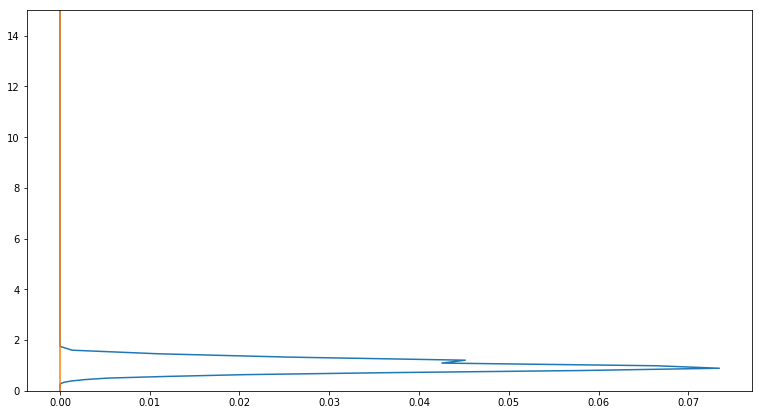

In [180]:
fig = plt.figure(figsize=[13,7])
plt.plot(m_clwc*1000.0, ht/1000.0)
plt.plot(m_ciwc*1000.0, ht/1000.0)
plt.ylim([0,15])

1243

In [100]:
levels.shape

(138, 9)

In [106]:
pres[0]

4.6660839999999997

In [107]:
levels.shape

(138, 9)

In [154]:
print(lst[10][3:11])
print(lst[10][11:19])

06260000
06270300


In [183]:
gen_hour = np.array([dt.hour for dt in stt])
np.unique(gen_hour)


array([ 0, 12])

In [162]:
stt, ett = file_list_to_date(lst)

In [165]:
ett

[datetime.datetime(2017, 6, 26, 0, 0),
 datetime.datetime(2017, 6, 26, 0, 1),
 datetime.datetime(2017, 6, 26, 3, 0),
 datetime.datetime(2017, 6, 26, 6, 0),
 datetime.datetime(2017, 6, 26, 9, 0),
 datetime.datetime(2017, 6, 26, 12, 0),
 datetime.datetime(2017, 6, 26, 15, 0),
 datetime.datetime(2017, 6, 26, 18, 0),
 datetime.datetime(2017, 6, 26, 21, 0),
 datetime.datetime(2017, 6, 27, 0, 0),
 datetime.datetime(2017, 6, 27, 3, 0),
 datetime.datetime(2017, 6, 27, 6, 0),
 datetime.datetime(2017, 6, 27, 9, 0),
 datetime.datetime(2017, 6, 27, 12, 0),
 datetime.datetime(2017, 6, 27, 15, 0),
 datetime.datetime(2017, 6, 27, 18, 0),
 datetime.datetime(2017, 6, 27, 21, 0),
 datetime.datetime(2017, 6, 28, 0, 0),
 datetime.datetime(2017, 6, 28, 3, 0),
 datetime.datetime(2017, 6, 28, 6, 0),
 datetime.datetime(2017, 6, 28, 9, 0),
 datetime.datetime(2017, 6, 28, 12, 0),
 datetime.datetime(2017, 6, 28, 15, 0),
 datetime.datetime(2017, 6, 28, 18, 0),
 datetime.datetime(2017, 6, 28, 21, 0),
 datetime.dat

In [197]:
grbs.close()

In [202]:
var_list = ['Specific cloud liquid water content', 'Specific cloud ice water content']

In [204]:
my_bundle, my_these_valid_times, my_these_run_times, my_lats, my_lons = create_bundle_latest(var_list)

D1D06261200062612011
D1D06261200062615001
D1D06261200062618001
D1D06261200062621001
D1D06261200062700001
D1D06261200062703001
D1D06261200062706001
D1D06261200062709001
D1D06261200062712001
D1D06261200062715001
D1D06261200062718001
D1D06261200062721001
D1D06261200062800001
D1D06261200062803001
D1D06261200062806001
D1D06261200062809001
D1D06261200062812001
D1D06261200062815001
D1D06261200062818001
D1D06261200062821001
D1D06261200062900001
D1D06261200062903001
D1D06261200062906001
D1D06261200062909001
D1D06261200062912001
D1D06261200062915001
D1D06261200062918001
D1D06261200062921001
D1D06261200063000001
D1D06261200063003001
D1D06261200063006001
D1D06261200063009001
D1D06261200063012001
D1D06261200063015001
D1D06261200063018001
D1D06261200063021001
D1D06261200070100001
D1D06261200070103001
D1D06261200070106001
D1D06261200070109001
D1D06261200070112001
D1D06261200070115001
D1D06261200070118001
D1D06261200070121001
D1D06261200070200001
D1D06261200070203001
D1D06261200070206001
D1D0626120007

In [205]:
import pickle
pickle.dump( [my_bundle, my_these_valid_times, my_these_run_times, my_lats, my_lons], open( "/data/ecmwf_bundle.p", "wb" ) )

In [311]:
my_unwind = concat_bundle(my_bundle)
my_dataset = unwind_to_xarray(my_unwind, my_these_valid_times, my_lats, my_lons)

In [312]:
my_dataset

<xarray.Dataset>
Dimensions:                              (time: 65, x: 111, y: 81, z: 136)
Coordinates:
    lat                                  (y, x) float64 43.0 43.0 43.0 43.0 ...
  * time                                 (time) datetime64[ns] 2017-06-26T12:01:00 ...
    lon                                  (y, x) float64 329.0 329.1 329.2 ...
  * z                                    (z) float64 8.03e+04 7.458e+04 ...
Dimensions without coordinates: x, y
Data variables:
    Specific_cloud_liquid_water_content  (time, z, y, x) float64 0.0 0.0 0.0 ...
    Specific_cloud_ice_water_content     (time, z, y, x) float64 0.0 0.0 0.0 ...

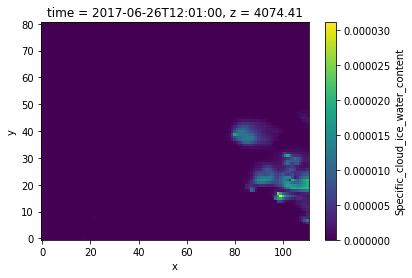

In [313]:
ds.Specific_cloud_ice_water_content[0][100].plot()

In [318]:
def plot_xarray_slice(item, level, timestep, vmin, vmax, units):
    plt.figure(figsize=(17,10))
    ter_lat = 38.7216
    ter_lon = -27.2206
    gra_lat = 39.0525
    gra_lon = -28.0069



    ax = plt.axes(projection=ccrs.PlateCarree())

    cf = item[timestep][level].plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(),
                                    x='lon', y='lat', add_colorbar=False, vmin = vmin, vmax = vmax)
    ax.set_xticks([-23, -24, -26, -28 ], crs=ccrs.PlateCarree())
    ax.set_yticks([37,39,41], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

    ax.plot([ter_lon, gra_lon], [ter_lat, gra_lat],
           'ro', transform=ccrs.PlateCarree())

    ax.text(ter_lon+.2, ter_lat+.2,
            'Tericia', transform=ccrs.PlateCarree(), fontsize = 16)

    ax.text(gra_lon+.2, gra_lat+.2,
            'Graciosa', transform=ccrs.PlateCarree(), fontsize = 16)


    coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',
                                    facecolor='none', name='coastline')

    _ = ax.add_feature(coast, edgecolor='black')

    plt.colorbar(cf, ax=ax, fraction=0.032, label = units)





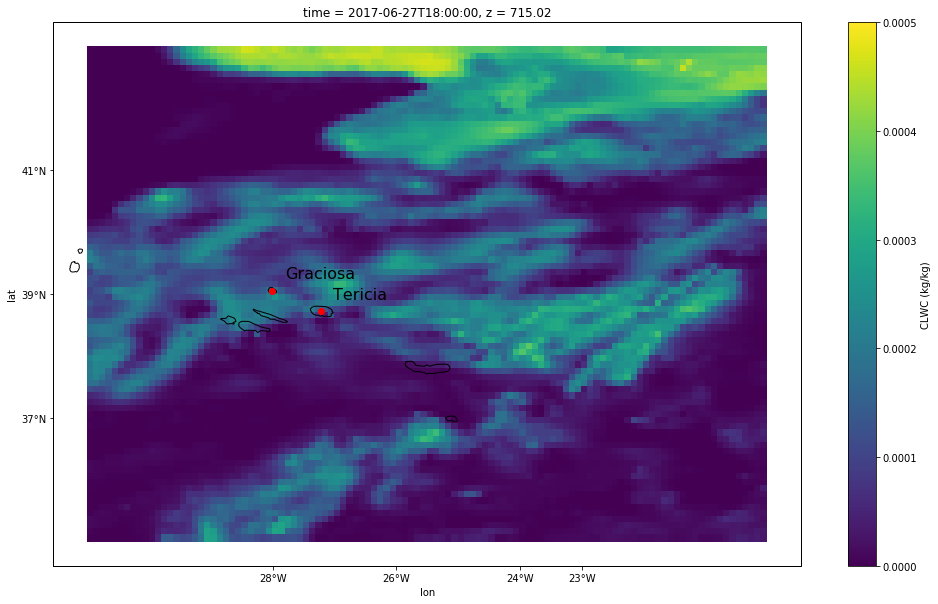

In [324]:
plot_xarray_slice(my_dataset.Specific_cloud_liquid_water_content,
                  120, 10, 0.0, 0.5/1000.0, 'CLWC (kg/kg)')

/data/aceena_x00.png
/data/aceena_x01.png
/data/aceena_x02.png
/data/aceena_x03.png
/data/aceena_x04.png
/data/aceena_x05.png
/data/aceena_x06.png
/data/aceena_x07.png
/data/aceena_x08.png
/data/aceena_x09.png
/data/aceena_x10.png
/data/aceena_x11.png
/data/aceena_x12.png
/data/aceena_x13.png
/data/aceena_x14.png
/data/aceena_x15.png
/data/aceena_x16.png
/data/aceena_x17.png
/data/aceena_x18.png
/data/aceena_x19.png
/data/aceena_x20.png


/Users/scollis/anaconda/envs/houston/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


/data/aceena_x21.png
/data/aceena_x22.png
/data/aceena_x23.png
/data/aceena_x24.png
/data/aceena_x25.png
/data/aceena_x26.png
/data/aceena_x27.png
/data/aceena_x28.png
/data/aceena_x29.png


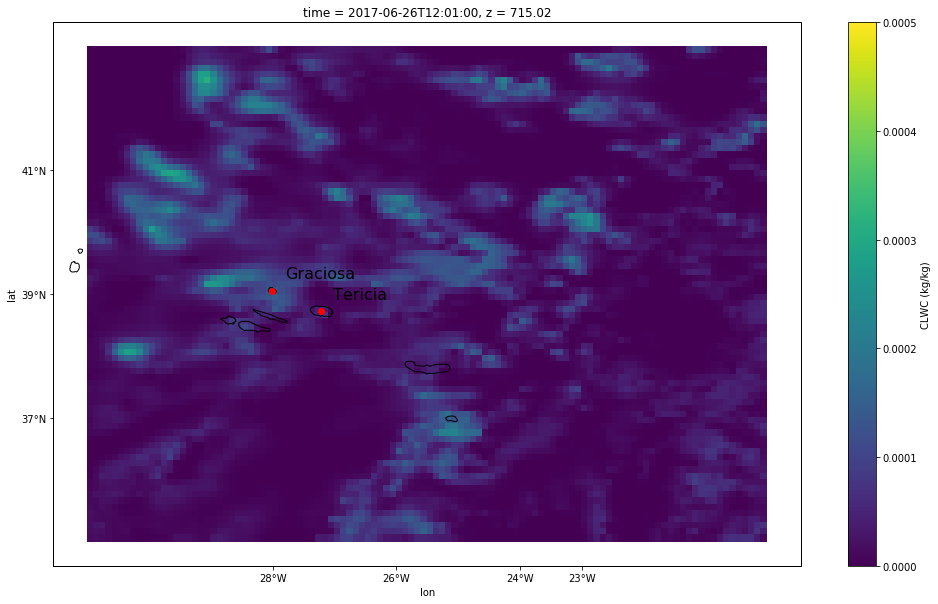

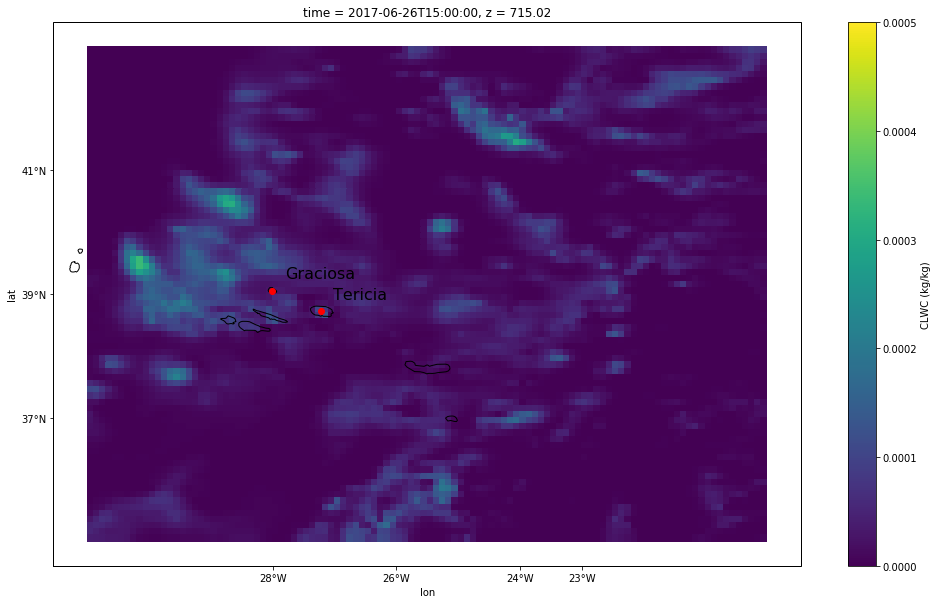

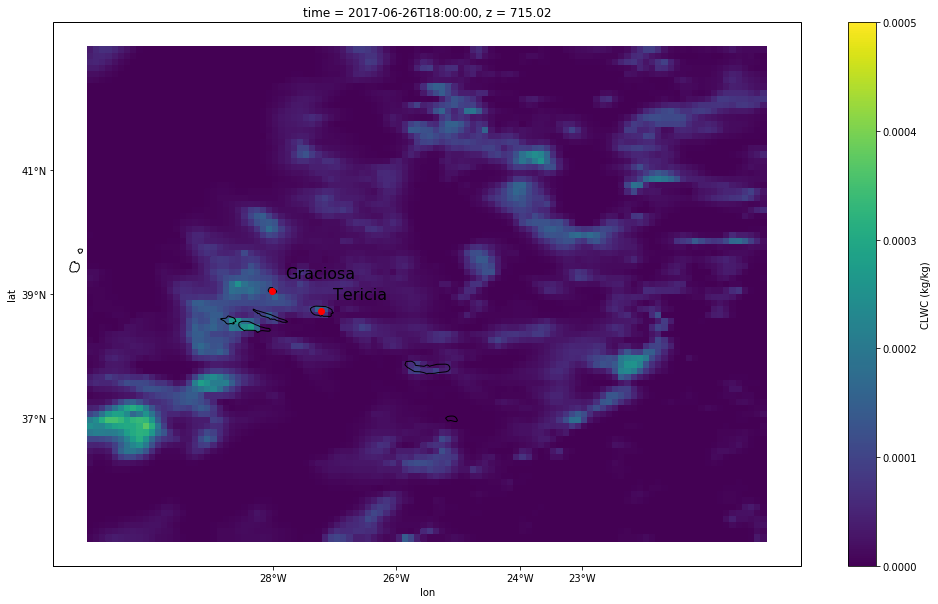

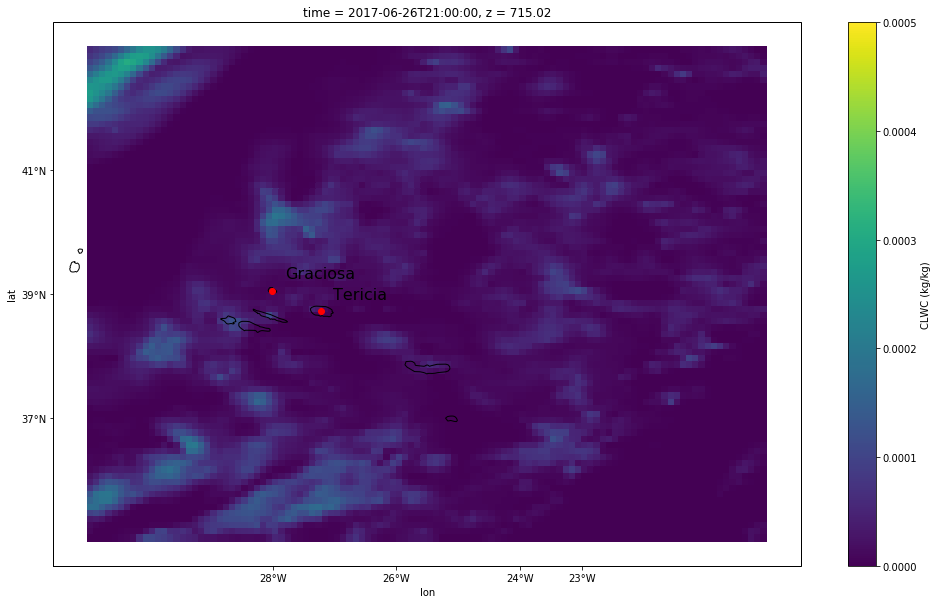

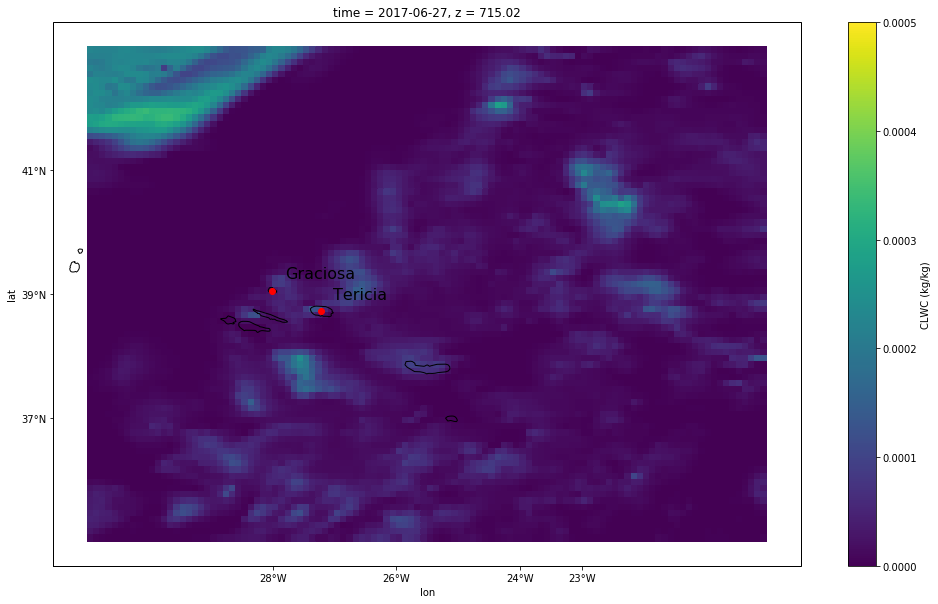

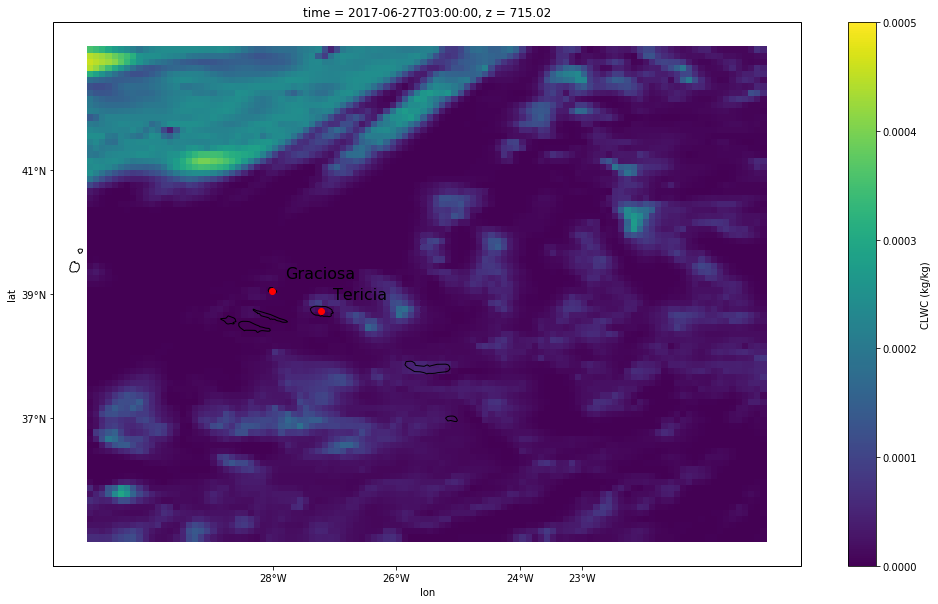

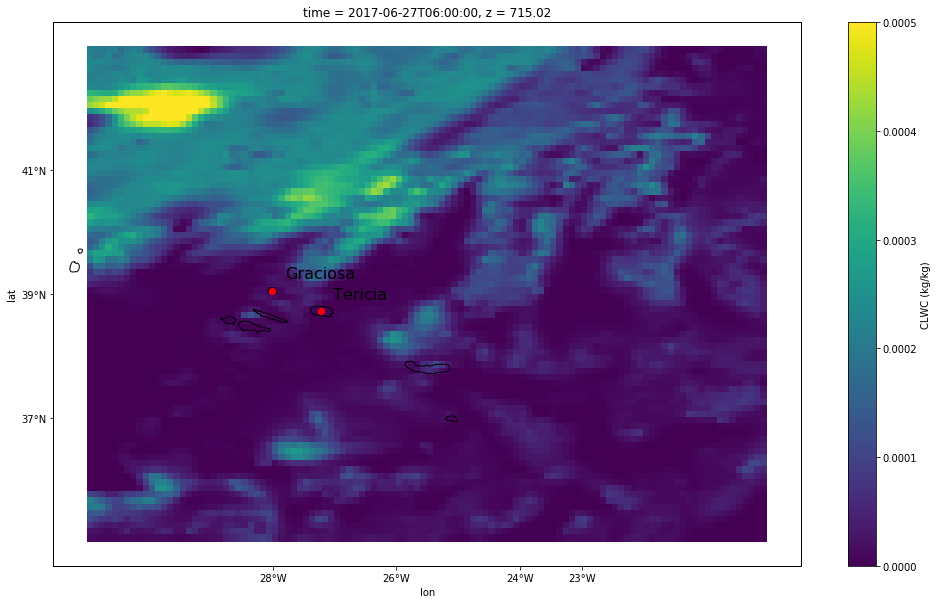

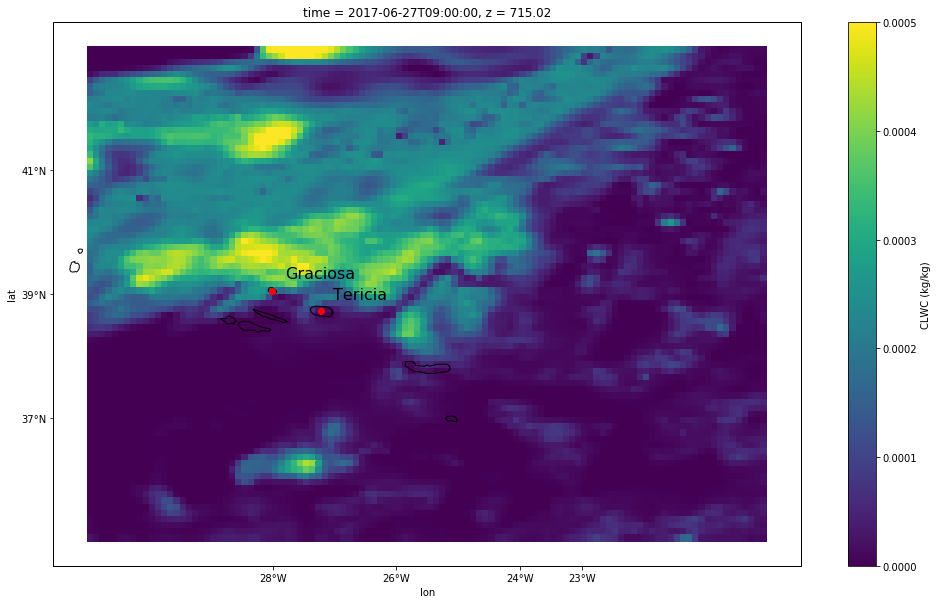

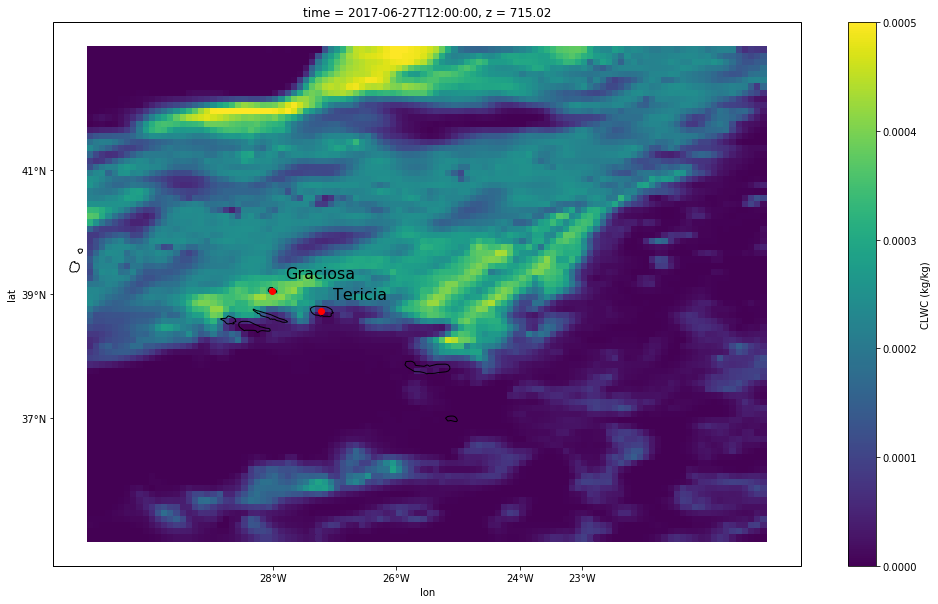

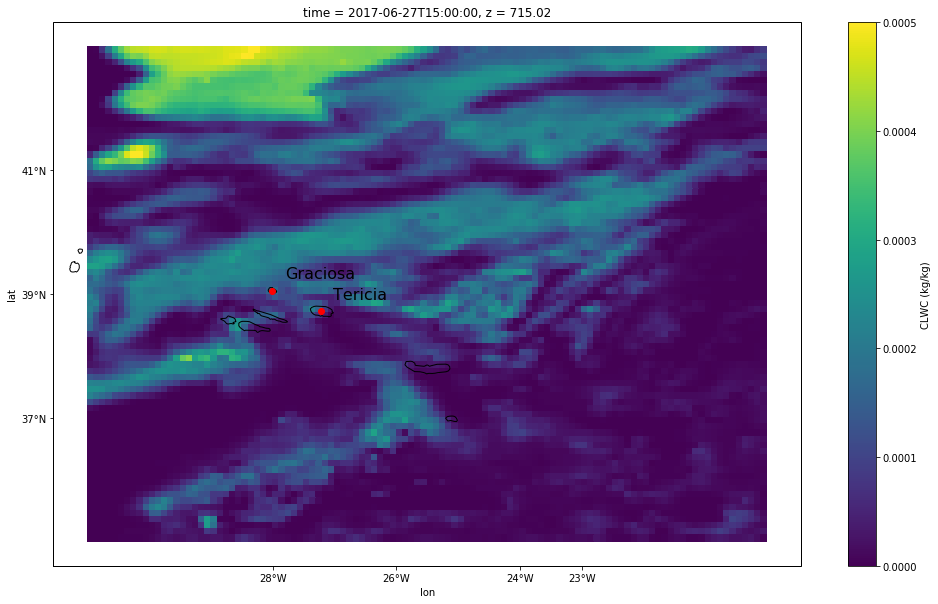

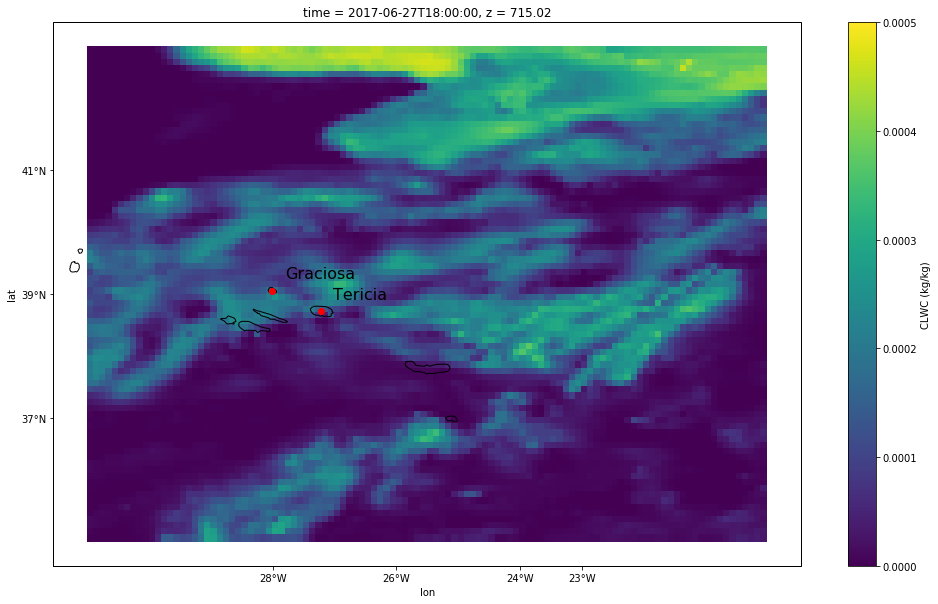

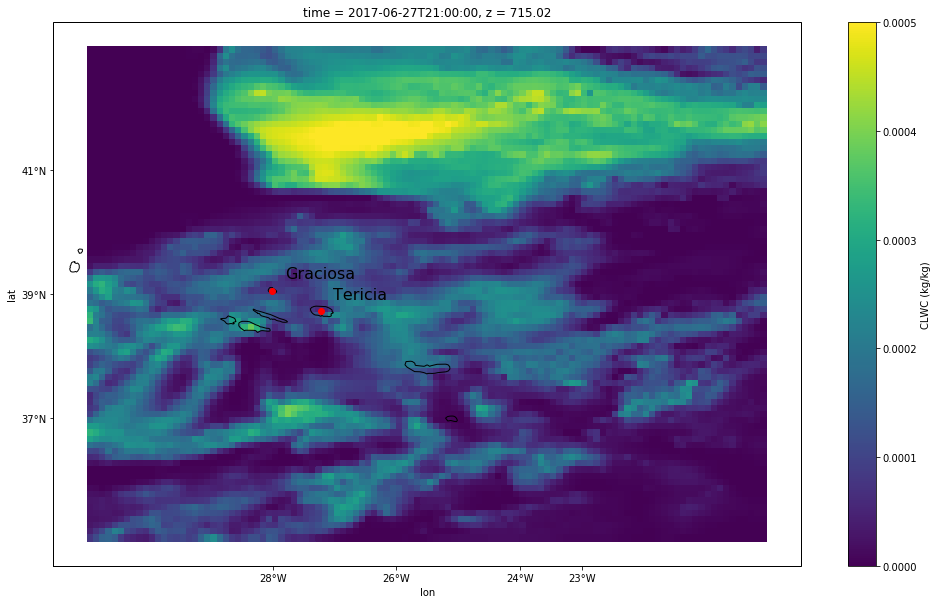

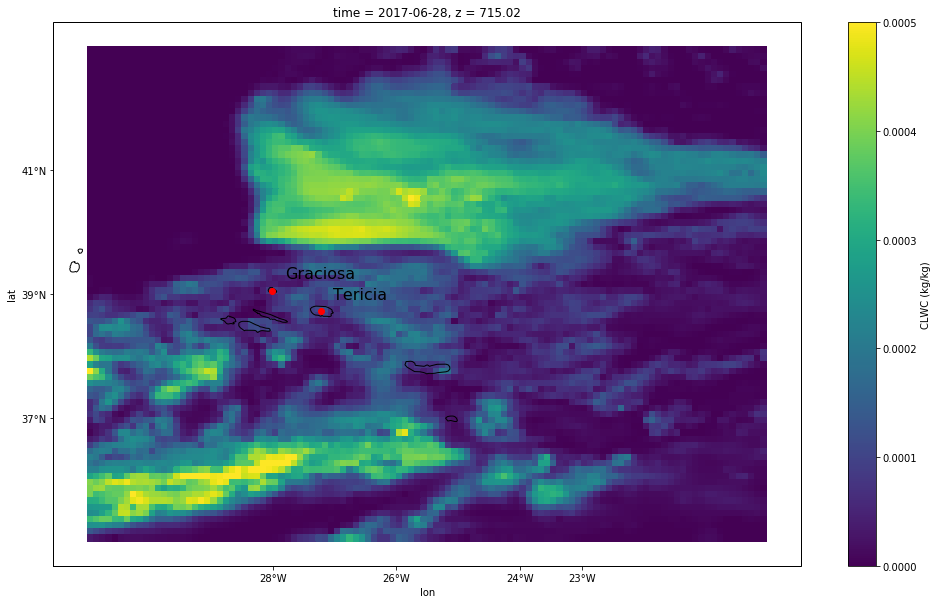

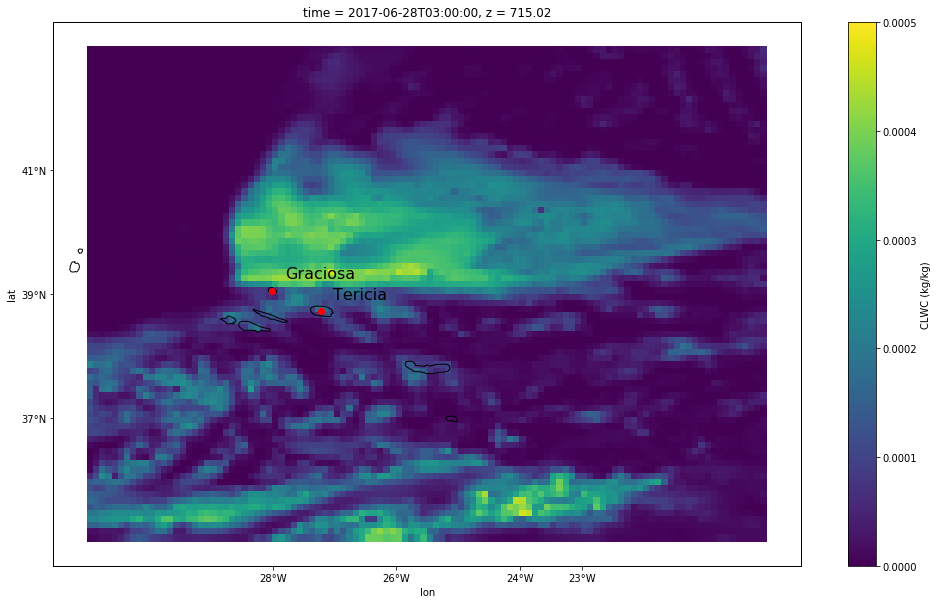

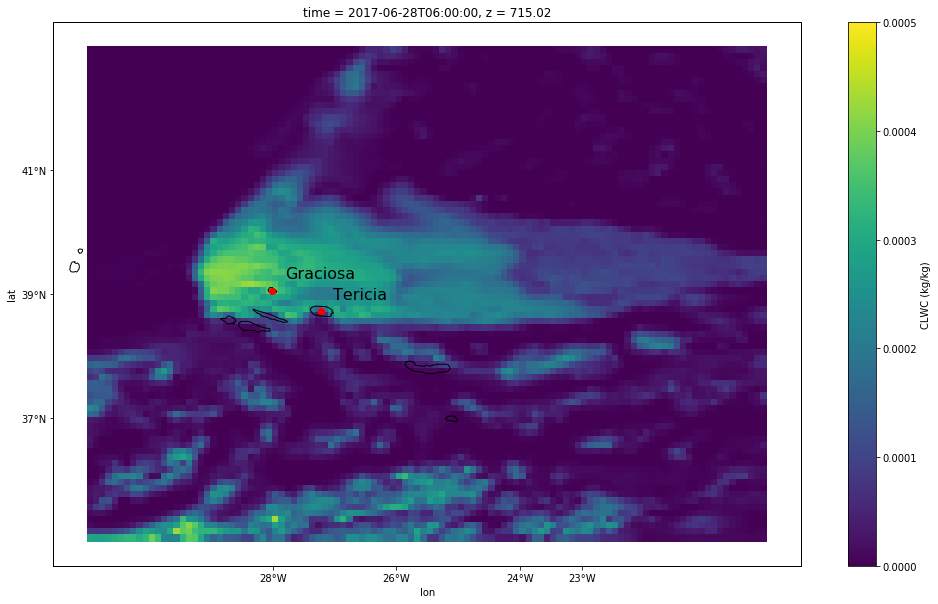

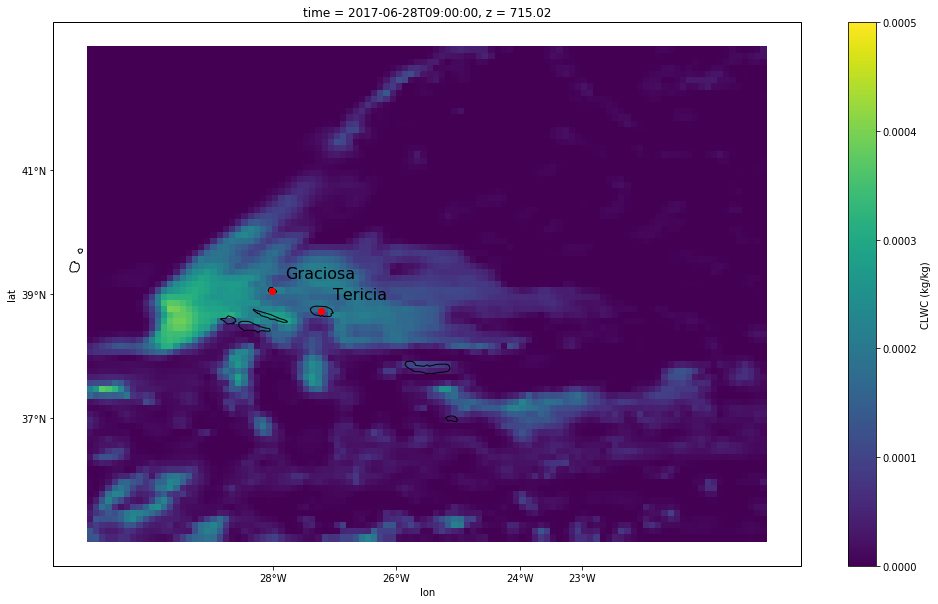

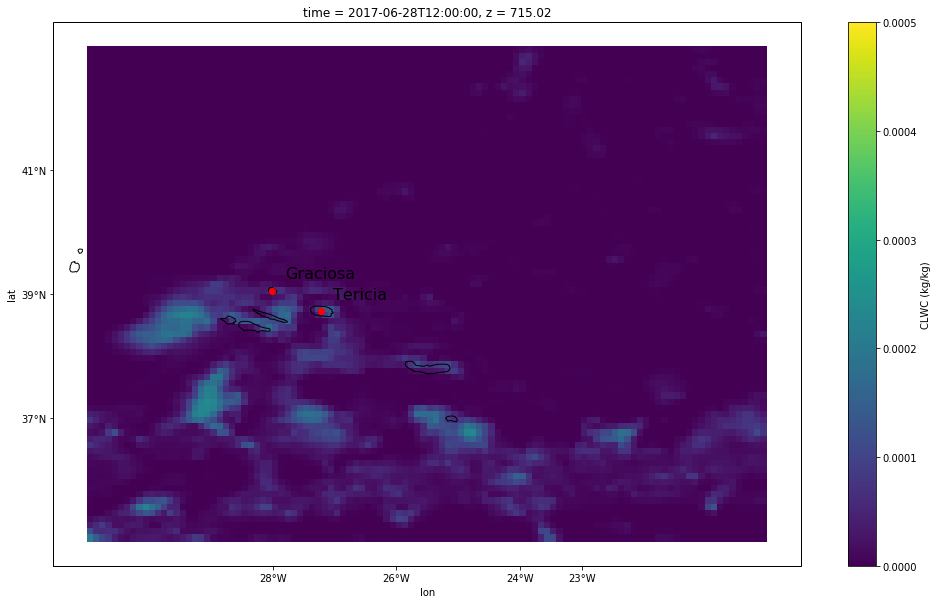

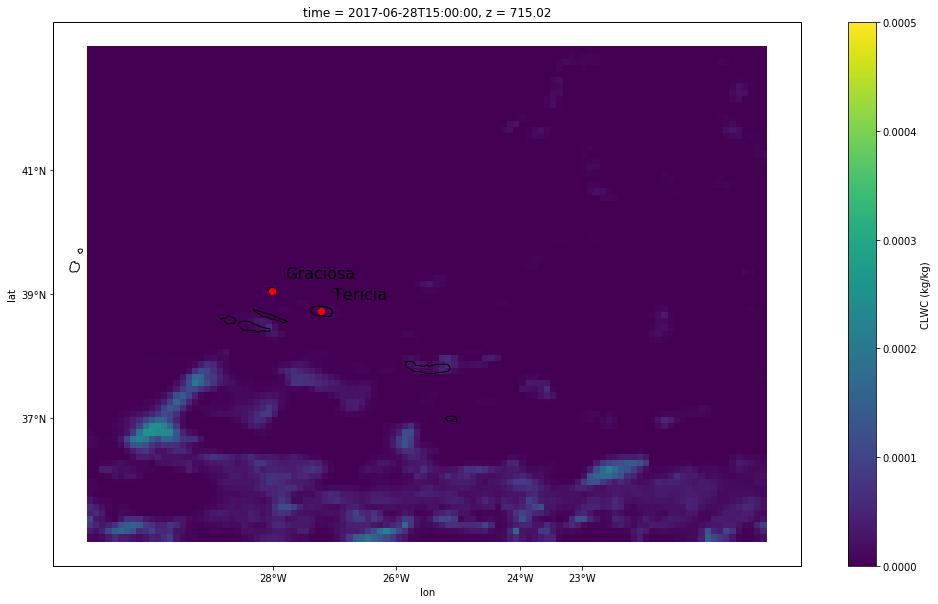

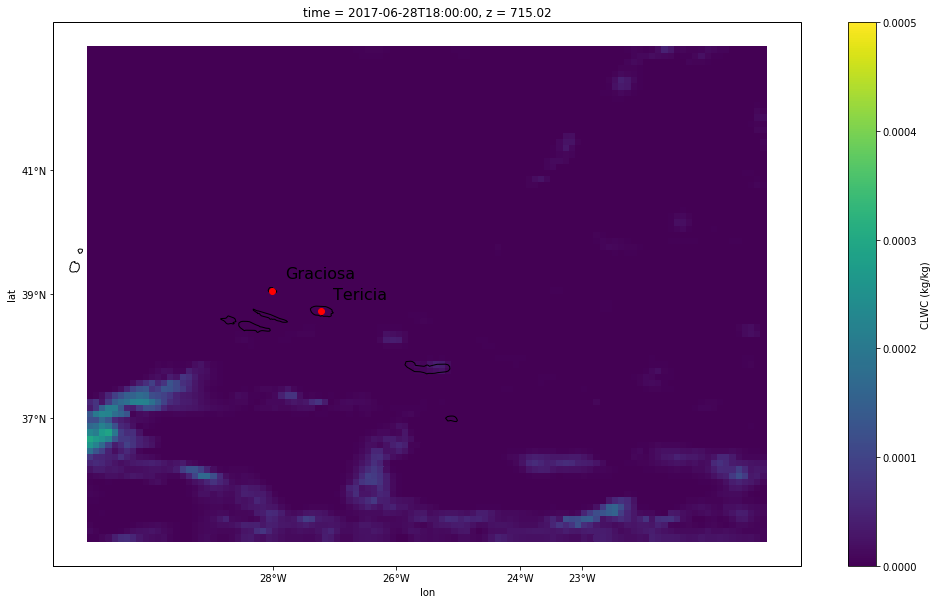

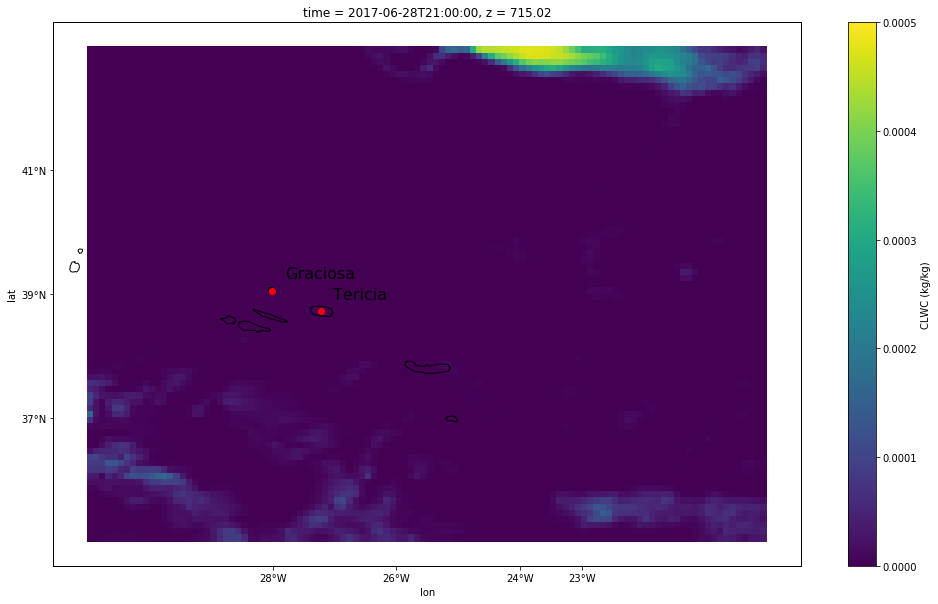

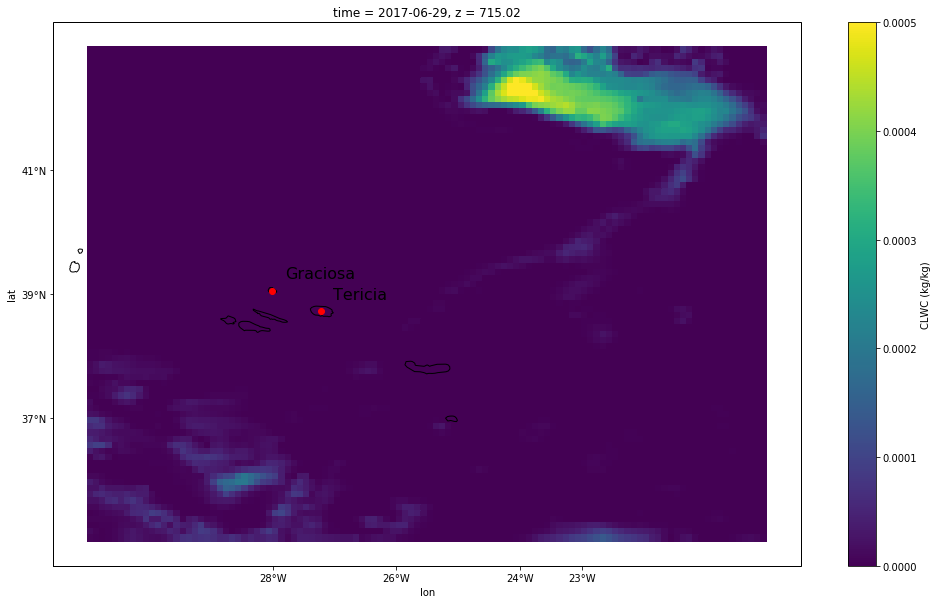

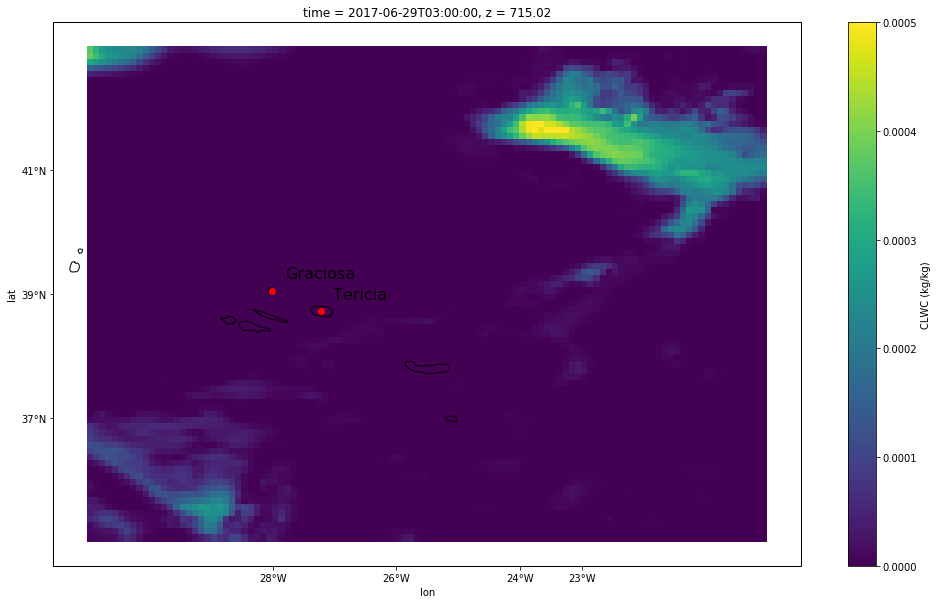

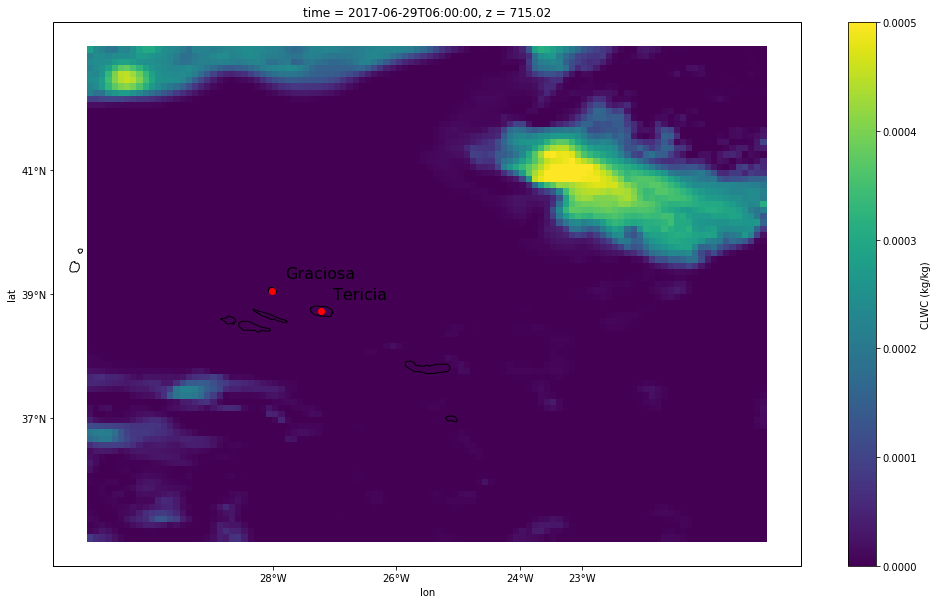

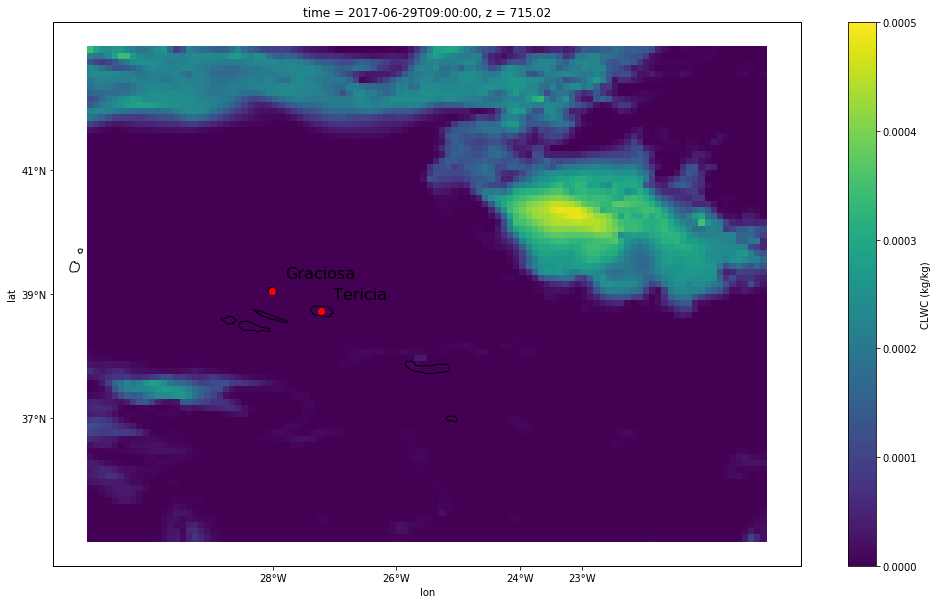

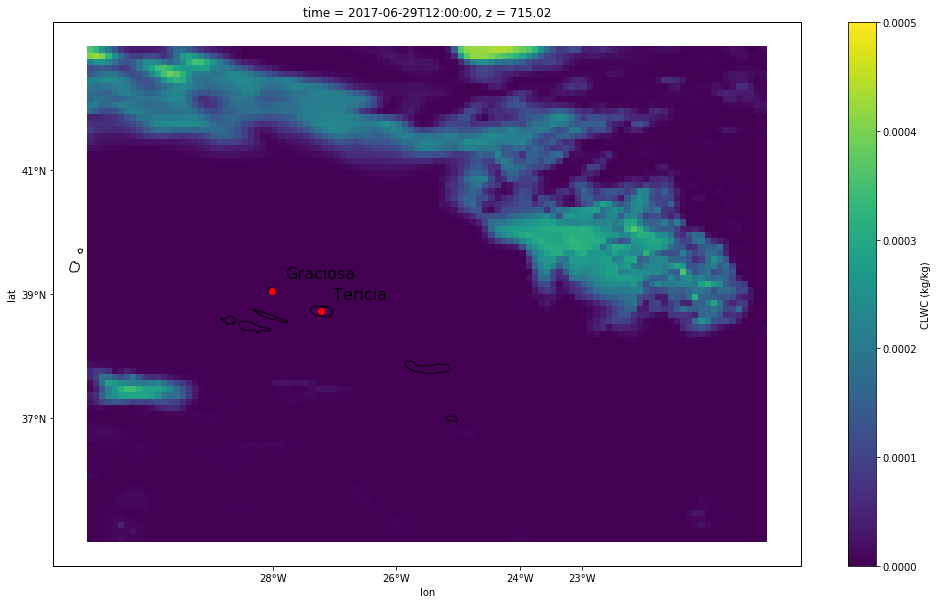

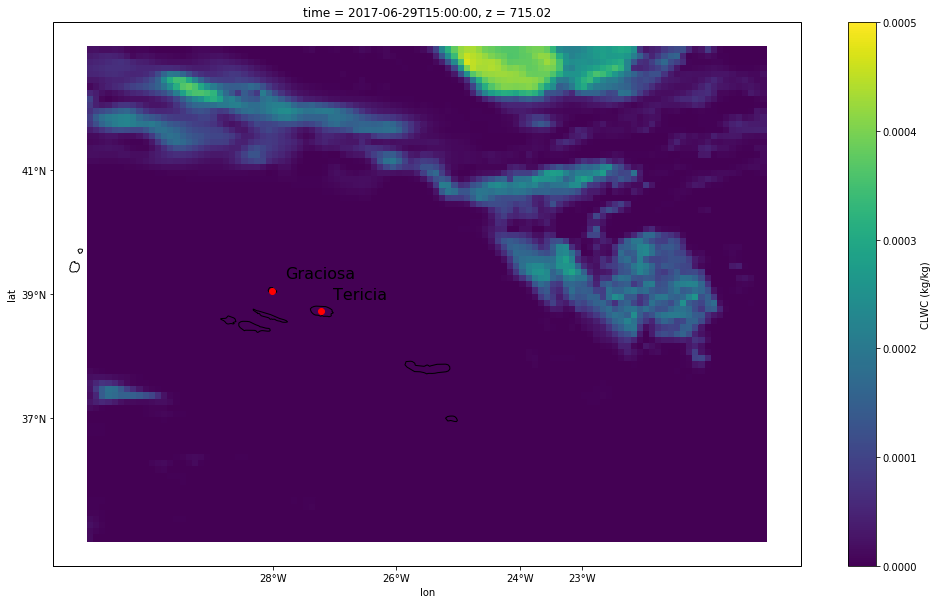

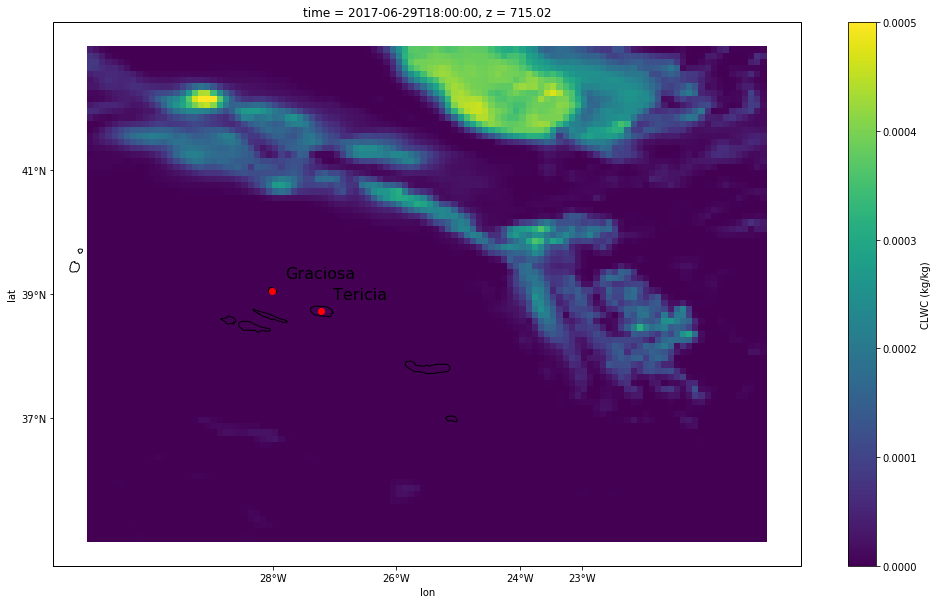

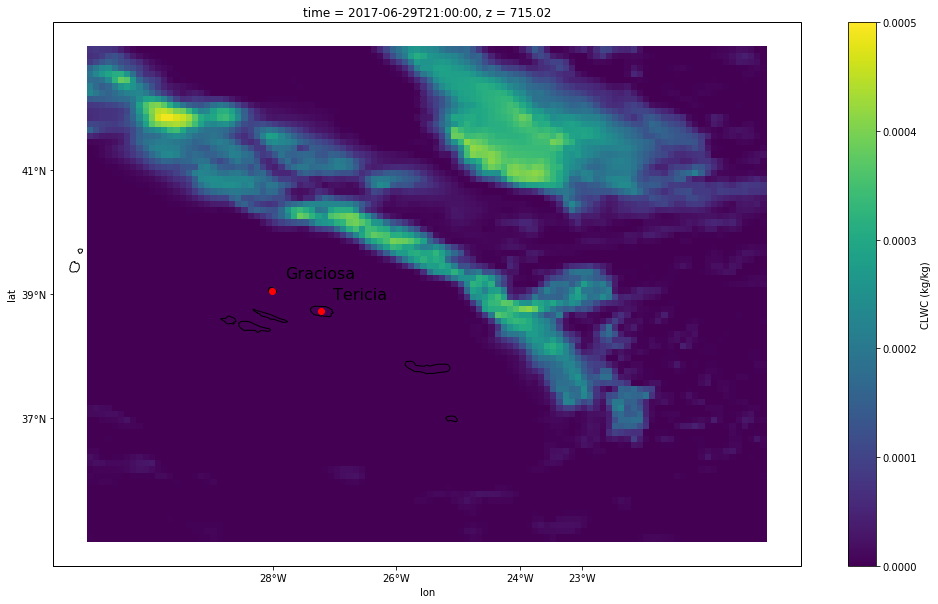

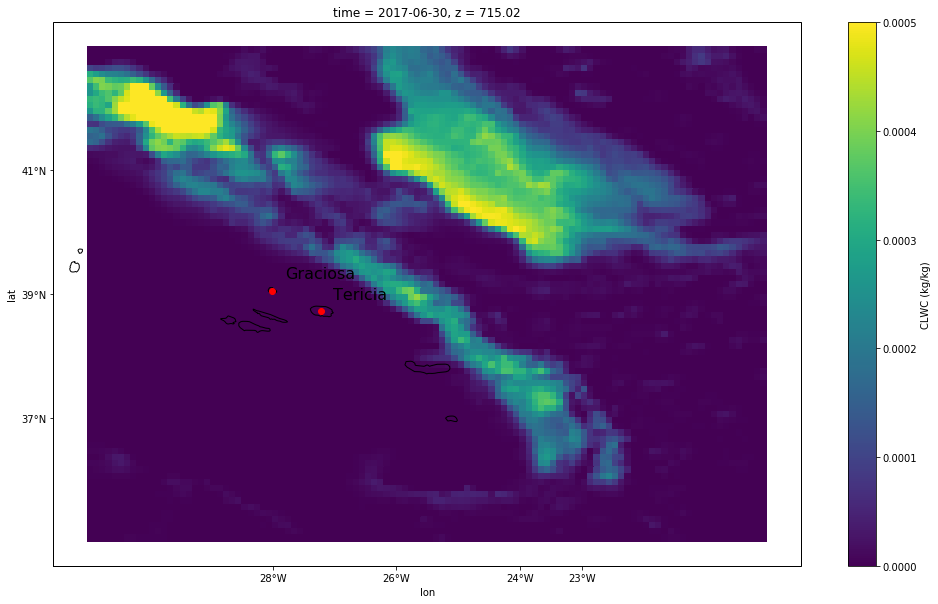

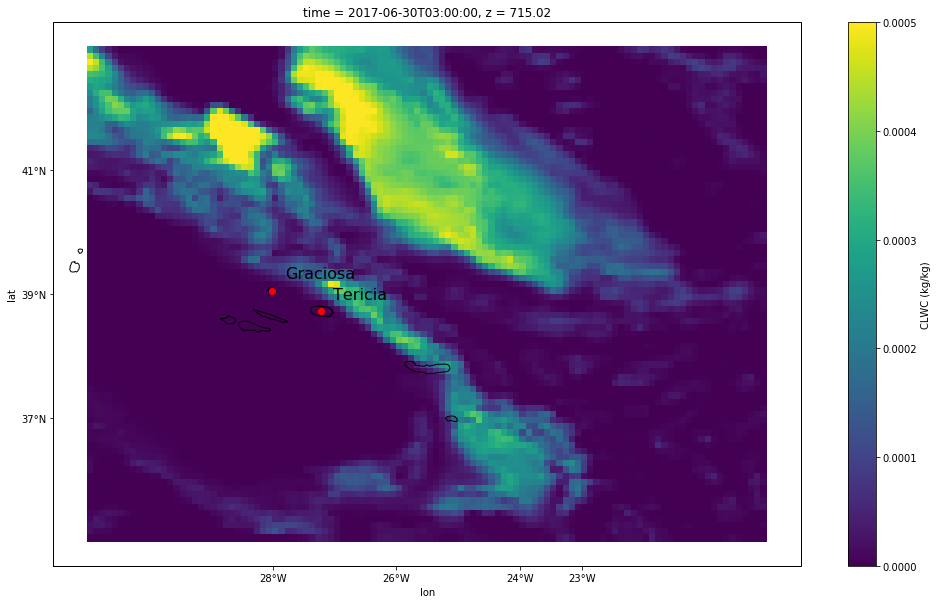

In [334]:
for i in range(30):
    filename = '/data/aceena_x{0:02d}.png'.format(i)
    print(filename)
    plot_xarray_slice(my_dataset.Specific_cloud_liquid_water_content,
                  120, i, 0.0, 0.5/1000.0, 'CLWC (kg/kg)')
    plt.savefig(filename)

In [317]:
ds.to_netcdf('/data/testme_xa.nc')

In [ ]:
#my_bundle, my_these_valid_times, my_these_run_times, my_lats, my_lons